In [52]:
import ast
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from orion.benchmark import BENCHMARK_DATA

from analysis import table_2

In [156]:
df = pd.read_csv('benchmark.csv')
df.head()

,dataset,pipeline,signal,iteration,f1,recall,precision,tn,fp,fn,tp,status,elapsed,split,run_id
0,MSL,aer,C-1,0,0.285714,0.5,0.2,NaN,4,1,1,OK,32.571009,True,ba2121f9-a
1,MSL,aer,C-2,0,0.666667,0.5,1.0,NaN,0,1,1,OK,15.664007,True,ba2121f9-a
2,MSL,aer,D-14,0,1.000000,1.0,1.0,NaN,0,0,2,OK,29.114218,True,ba2121f9-a
3,MSL,aer,D-15,0,NaN,0.0,NaN,NaN,0,1,0,OK,31.796568,True,ba2121f9-a
4,MSL,aer,D-16,0,1.000000,1.0,1.0,NaN,0,0,1,OK,22.084192,True,ba2121f9-a


In [157]:
DATASET_ABBREVIATION = {
    "MSL": "MSL",
    "SMAP": "SMAP",
    "YAHOOA1": "A1",
    "YAHOOA2": "A2",
    "YAHOOA3": "A3",
    "YAHOOA4": "A4",
    "artificialWithAnomaly": "Art",
    "realAWSCloudwatch": "AWS",
    "realAdExchange": "AdEx",
    "realTraffic": "Traf",
    "realTweets": "Tweets"
}

DATASET_FAMILY = {
    "MSL": "NASA",
    "SMAP": "NASA",
    "YAHOOA1": "YAHOO",
    "YAHOOA2": "YAHOO",
    "YAHOOA3": "YAHOO",
    "YAHOOA4": "YAHOO",
    "artificialWithAnomaly": "NAB",
    "realAWSCloudwatch": "NAB",
    "realAdExchange": "NAB",
    "realTraffic": "NAB",
    "realTweets": "NAB"
}

In [158]:
df = df.groupby(['dataset', 'pipeline', 'iteration'])[['fp', 'fn', 'tp']].sum().reset_index()

precision = df['tp'] / (df['tp'] + df['fp'])
recall = df['tp'] / (df['tp'] + df['fn'])
df['precision'] = precision
df['recall'] = recall
df['f1'] = 2 * (precision * recall) / (precision + recall)

df = df.set_index(['dataset', 'pipeline', 'iteration'])[['f1', 'precision', 'recall']].reset_index()
df['family'] = df['dataset'].apply(lambda x: DATASET_FAMILY[x])
df['dataset'] = df['dataset'].apply(lambda x: DATASET_ABBREVIATION[x])

In [159]:
df

,dataset,pipeline,iteration,f1,precision,recall,family
0,MSL,aer,0,0.631579,0.600000,0.666667,NASA
1,MSL,aer,1,0.637681,0.666667,0.611111,NASA
2,MSL,aer,2,0.594595,0.578947,0.611111,NASA
3,MSL,aer,3,0.597403,0.560976,0.638889,NASA
4,MSL,aer,4,0.619718,0.628571,0.611111,NASA
...,...,...,...,...,...,...,...
490,Tweets,vae,0,0.566667,0.629630,0.515152,NAB
491,Tweets,vae,1,0.551724,0.640000,0.484848,NAB
492,Tweets,vae,2,0.542373,0.615385,0.484848,NAB
493,Tweets,vae,3,0.508475,0.576923,0.454545,NAB


In [164]:
data = df.groupby(['dataset', 'family', 'pipeline'])[['recall']].agg(["mean", "std"]).droplevel(0, axis=1)
data['value'] = data["mean"].round(3).astype("str") + "+-" + data["std"].round(2).astype("str")

data = data[['value']].unstack().T.droplevel(0)
# data.columns = [DATASET_ABBREVIATION[col] for col in data.columns]
# data.columns = pd.MultiIndex.from_tuples(list(zip(DATASET_FAMILY.values(), data.columns)))
# data = data[['NASA', 'YAHOO', 'NAB']]
data = data[['MSL', 'SMAP', 'A1', 'A2', 'A3', 'A4', 'Art', 'AWS', 'AdEx', 'Traf', 'Tweets']]
data = data.swaplevel(axis=1).loc[_ORDER]
data.index = _LABELS
print(data.to_latex())

\begin{tabular}{llllllllllll}
\toprule
family & \multicolumn{2}{l}{NASA} & \multicolumn{4}{l}{YAHOO} & \multicolumn{5}{l}{NAB} \\
dataset &          MSL &         SMAP &           A1 &           A2 &           A3 &           A4 &          Art &          AWS &         AdEx &         Traf &       Tweets \\
\midrule
AER      &  0.628+-0.02 &  0.749+-0.02 &  0.755+-0.01 &   0.985+-0.0 &  0.799+-0.01 &  0.577+-0.01 &  0.867+-0.14 &  0.673+-0.01 &  0.945+-0.05 &  0.886+-0.08 &  0.564+-0.02 \\
LSTM DT  &    0.7+-0.01 &  0.773+-0.01 &  0.784+-0.02 &   0.984+-0.0 &   0.59+-0.01 &  0.508+-0.01 &  0.533+-0.07 &  0.607+-0.01 &     1.0+-0.0 &    0.9+-0.04 &  0.606+-0.02 \\
ARIMA    &   0.417+-0.0 &   0.343+-0.0 &   0.815+-0.0 &   0.865+-0.0 &   0.643+-0.0 &   0.533+-0.0 &     0.5+-0.0 &   0.567+-0.0 &   0.727+-0.0 &   0.429+-0.0 &   0.606+-0.0 \\
LSTM AE  &  0.489+-0.03 &   0.71+-0.01 &  0.571+-0.01 &  0.917+-0.02 &  0.289+-0.01 &  0.141+-0.01 &    0.6+-0.09 &    0.7+-0.02 &  0.709+-0.13 &  0.543+-

In [107]:
_ORDER = ['aer', 'lstm_dynamic_threshold', 'arima', 'lstm_autoencoder', 'tadgan', 'vae', 'dense_autoencoder', 'ganf', 'azure']
_LABELS = ['AER', 'LSTM DT', 'ARIMA', 'LSTM AE', 'TadGAN', 'VAE', 'Dense AE', 'GANF', 'Azure AD']

Text(0.5, 1.0, 'NAB')

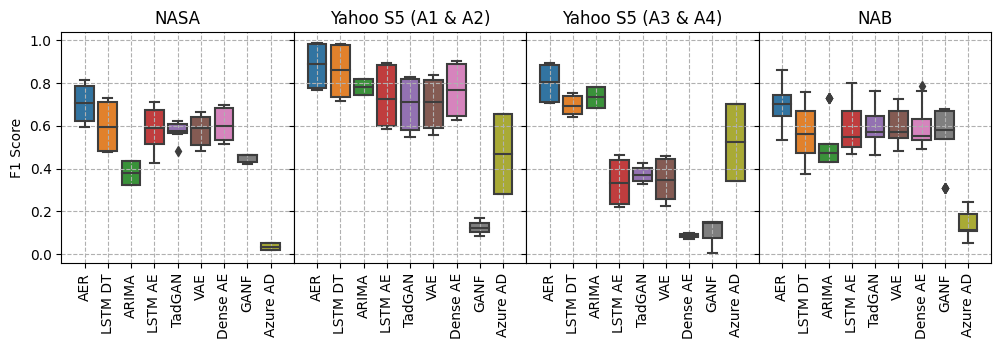

In [166]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(12, 3))
fig.subplots_adjust(wspace=0)

data = df.set_index('pipeline').loc[_ORDER].reset_index()

sns.boxplot(data[data['family'] == 'NASA'], x='pipeline', y='f1', ax=axes[0])
sns.boxplot(data[data['dataset'].isin(['A1', 'A2'])], x='pipeline', y='f1', ax=axes[1])
sns.boxplot(data[data['dataset'].isin(['A3', 'A4'])], x='pipeline', y='f1', ax=axes[2])
sns.boxplot(data[data['family'] == 'NAB'], x='pipeline', y='f1', ax=axes[3])

for i in range(4):
    axes[i].grid(True, linestyle='--')
    axes[i].set_xticklabels(_LABELS, rotation=90)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    
axes[0].set_xlim(-1, 9)
axes[0].set_ylabel('F1 Score')

axes[0].set_title("NASA")
axes[1].set_title("Yahoo S5 (A1 & A2)")
axes[2].set_title("Yahoo S5 (A3 & A4)")
axes[3].set_title("NAB")

# plt.legend(bbox_to_anchor=(1.05, 0.85), edgecolor='black')

Text(0.5, 1.0, 'Pipeline Elapsed Time')

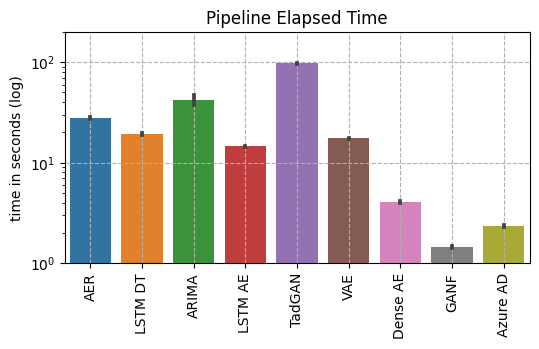

In [187]:
df = pd.read_csv('benchmark.csv')

df['family'] = df['dataset'].apply(lambda x: DATASET_FAMILY[x])
df['dataset'] = df['dataset'].apply(lambda x: DATASET_ABBREVIATION[x])
df = df.set_index('pipeline').loc[_ORDER].reset_index()

fig = plt.figure(figsize=(6, 3))
ax = plt.gca()
    
sns.barplot(data=df, x="pipeline", y="elapsed", ax=ax)

ax.set_xticklabels(_LABELS, rotation=90)

plt.grid(True, linestyle='--')
plt.yscale('log')
plt.ylim([0.1e1, 0.2e3])
plt.ylabel('time in seconds (log)')
plt.xlabel('')
plt.title("Pipeline Elapsed Time")

In [ ]:
DATASET_INTERVAL = {
    "MSL": 21600,
    "SMAP": 21600,
    "YAHOOA1": 1,
    "YAHOOA2": 1,
    "YAHOOA3": 1,
    "YAHOOA4": 1,
    "artificialWithAnomaly": 600,
    "realAWSCloudwatch": 600,
    "realAdExchange": 3600,
    "realTraffic": 600,
    "realTweets": 600
}

In [37]:
BUCKET = 'sintel-orion-benchmark'
S3_URL = 'https://{}.s3.amazonaws.com/{}'

DATA_MAP = {signal: data for data, signals in BENCHMARK_DATA.items() for signal in signals}

data = pd.read_csv(S3_URL.format(BUCKET, 'anomalies.csv'))
data = data[data['signal'].isin(DATA_MAP.keys())]
anomalies = dict()
# data['anomaly_len'] = None
# data['anomaly_len'] = data['anomaly_len'].astype(object)

for i, row in tqdm(data.iterrows(), total=data.shape[0]):
    name = row['signal']
    dataset = DATA_MAP[name]
    interval = DATASET_INTERVAL[dataset]
    events = ast.literal_eval(row['events'])
    
    data.loc[i, 'signal_len'] = len(pd.read_csv(S3_URL.format(BUCKET, f'{name}.csv')))
    data.loc[i, 'dataset'] = dataset
    data.loc[i, 'interval'] = interval
    data.loc[i, 'count'] = len(events)
    anomalies[i] = [(t[1] - t[0]) / interval + 1 for t in events]
    
anomalies = pd.DataFrame([anomalies]).T
anomalies.columns = ['anomaly_len']
data = pd.concat([data, anomalies], axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 492/492 [01:40<00:00,  4.89it/s]


In [49]:
data.to_csv('data_summary.csv', index=False)

In [45]:
summary = data.groupby('dataset')['count'].agg(['count', 'sum'])
signals = data.groupby('dataset')['signal_len'].mean()
anomaly = data.groupby('dataset')['anomaly_len'].apply(lambda x: np.mean(list(itertools.chain.from_iterable(x))))
summary = pd.concat([summary, signals, anomaly], axis=1)
summary
# data
# anomaly

,count,sum,signal_len,anomaly_len
dataset,,,,
MSL,27,36.0,4890.592593,219.583333
SMAP,53,67.0,10618.867925,838.074627
YAHOOA1,67,178.0,1415.910448,9.376404
YAHOOA2,100,200.0,1421.000000,2.330000
YAHOOA3,100,939.0,1680.000000,1.004260
YAHOOA4,100,835.0,1680.000000,1.002395
artificialWithAnomaly,6,6.0,4032.000000,202.000000
realAWSCloudwatch,17,30.0,3980.352941,105.766667
realAdExchange,5,11.0,1593.400000,73.454545


In [46]:
summary['sum'].sum()

2349.0

In [62]:
anomalies.groupby('dataset')['count'].agg(['count', 'sum'])

,count,sum
dataset,,
MSL,27,36
SMAP,53,67
YAHOOA1,67,178
YAHOOA2,100,200
YAHOOA3,100,939
YAHOOA4,100,835
artificialWithAnomaly,6,6
realAWSCloudwatch,17,30
realAdExchange,5,11


In [ ]:
# dataset details
df = pd.read_csv("orion/data/anomalies.csv")
df['events'] = df['events'].apply(lambda x: ast.literal_eval(x))
df['events'].apply(lambda x: len(x))

In [29]:
# benchmark details

df = pd.read_csv('benchmark.csv')
df.head()

,dataset,pipeline,signal,iteration,f1,recall,precision,tn,fp,fn,tp,status,elapsed,split,run_id
0,MSL,aer,C-1,0,0.285714,0.5,0.2,NaN,4,1,1,OK,32.571009,True,ba2121f9-a
1,MSL,aer,C-2,0,0.666667,0.5,1.0,NaN,0,1,1,OK,15.664007,True,ba2121f9-a
2,MSL,aer,D-14,0,1.000000,1.0,1.0,NaN,0,0,2,OK,29.114218,True,ba2121f9-a
3,MSL,aer,D-15,0,NaN,0.0,NaN,NaN,0,1,0,OK,31.796568,True,ba2121f9-a
4,MSL,aer,D-16,0,1.000000,1.0,1.0,NaN,0,0,1,OK,22.084192,True,ba2121f9-a
